In [15]:
import pandas as pd
from UtilsCreateDataFrame import *
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np 
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy_ext as npe

In [16]:
df = pd.read_csv("BTC_ETH_2021-01.csv.gz")
df.index = pd.to_datetime(df.time)
df.drop(columns = "time", inplace = True)


@dataclass
class ResultLR:
    __slots__ = ('beta','intercept', 'r2', 'residuals',)
    beta : float
    intercept : float
    r2 : float
    residuals : np.array 


def linearRegression(df, x_name , y_name):
    """
    function that fits a linear regression and return several objects: 
    Inputs: 
        -df: pd.DataFrame
                pandas dataframe containing as columns the assets
        -x_name: str
                asset to use as x, e.g. "BTC"
        -y_name: str
                asset to use as y: e.g. "ETH"
    Outputs:
        -results: ResultLR
    
    """
    #create x vector and y vector 
    x = df[x_name].to_numpy().reshape(-1,1)
    y = df[y_name].to_numpy().reshape(-1,1)
    #fit the model
    mod = LinearRegression().fit(x, y)
    #predicted values
    pred = mod.predict(x).reshape(-1,1)
    r2 = r2_score(y_true = y, y_pred = pred)
    residuals = y.flatten() - pred.flatten()
    result = ResultLR(mod.coef_.item(), mod.intercept_.item(), r2, residuals)
    return result



def linearRegression_np(x , y):
    """
    function that fits a linear regression and return several objects: 
    Inputs: 
        -x: ndarray
        -y: ndarray
            
    Outputs:
        -results: ResultLR
    
    """
    #create x vector and y vector 
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    #fit the model
    mod = LinearRegression().fit(x, y)
    #predicted values
    pred = mod.predict(x).reshape(-1,1)
    r2 = r2_score(y_true = y, y_pred = pred)
    residuals = y.flatten() - pred.flatten()
    result = ResultLR(mod.coef_.item(), mod.intercept_.item(), r2, residuals)
    return result


In [17]:
#with 1minute frequency a day has 1140 observations
ndf = df.to_numpy()
testrolling = npe.rolling_apply(linearRegression_np , 1140, ndf[:,0], ndf[:,1])
index = ~pd.isnull(testrolling)
res = testrolling[index]

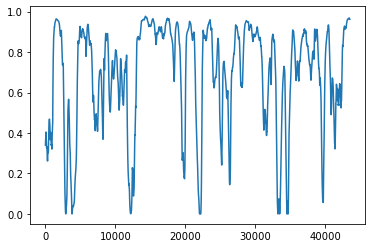

In [18]:
betas = np.array([j.beta for j in res])
r2s = np.array([j.r2 for j in res])
residuals = [j.residuals for j in res]
plt.plot(r2s)

In [19]:
num_nan = ndf.shape[0]-len(betas)
nans = [np.nan for j in range(num_nan)]
r2s = np.r_[nans, r2s]
betas = np.r_[nans, betas]

df["r2"] = r2s
df["beta"] = betas
df["residuals"] = nans + residuals

In [20]:
from statsmodels.tsa.stattools import adfuller

def isStationary(x):
    try:
        len(x) 
        test = adfuller(x)
        p_val = test[1]
        return p_val <= 0.05 
    except:
        return np.nan
        

In [21]:
%%time 
first = 30000
last = 31000
stat = df["residuals"][first:last].apply(lambda y : isStationary(y))

Wall time: 1min 20s


In [22]:
stat.sum()

69

In [24]:
stat

time
2021-01-21 20:00:00+00:00    False
2021-01-21 20:01:00+00:00    False
2021-01-21 20:02:00+00:00    False
2021-01-21 20:03:00+00:00    False
2021-01-21 20:04:00+00:00    False
                             ...  
2021-01-22 12:35:00+00:00    False
2021-01-22 12:36:00+00:00    False
2021-01-22 12:37:00+00:00    False
2021-01-22 12:38:00+00:00    False
2021-01-22 12:39:00+00:00    False
Name: residuals, Length: 1000, dtype: bool